In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install pdfminer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 34.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 51.7 MB/s eta 0:00:00
  Created wheel for pdfminer: filename=pdfminer-20191125-py3-none-any.whl size=6140091 sha256=186ba7504011fa03b487f74ced174b4d2e137ae330c1ffe8156e3d4fd5db5c83
  Stored in directory: /root/.cache/pip/wheels/56/24/93/05316c6df89ff210a9a705060277e3acbfd2d1bd3a5853ee19
Successfully built pdfminer


In [ ]:

! pip install pdfminer.six

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 26.4 MB/s eta 0:00:00


In [ ]:
!pip install python-docx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 4.0 MB/s eta 0:00:00


In [ ]:
import torch
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from pdfminer.high_level import extract_text
from docx import Document
from transformers import AutoModelForTokenClassification, AutoTokenizer, pipeline, BertTokenizer, BertForSequenceClassification

In [ ]:
# Load NLP model for Named Entity Recognition (NER)
LEGAL_BERT_MODEL = "nlpaueb/legal-bert-base-uncased"
legal_tokenizer = AutoTokenizer.from_pretrained(LEGAL_BERT_MODEL)
legal_model = AutoModelForTokenClassification.from_pretrained(LEGAL_BERT_MODEL)
legal_ner = pipeline("ner", model=legal_model, tokenizer=legal_tokenizer, aggregation_strategy="simple", device=0 if torch.cuda.is_available() else -1)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


In [ ]:
# Function to extract text from files
def extract_text_from_file(file_path):
    if file_path.endswith(".pdf"):
        return extract_text(file_path)
    elif file_path.endswith(".docx"):
        doc = Document(file_path)
        return "\n".join([para.text for para in doc.paragraphs])
    elif file_path.endswith(".txt"):
        with open(file_path, "r", encoding="utf-8") as f:
            return f.read()
    else:
        raise ValueError("Unsupported file format!")

In [ ]:
# Function to process text with NER
def process_text(text):
    return nlp_ner(text)

In [ ]:
# Function to clean extracted entities
def clean_entities(entities):
    cleaned = {}
    for entity in entities:
        word = entity.get("word", "").replace("##", "")
        label = entity.get("entity_group", "")
        if label not in cleaned:
            cleaned[label] = []
        cleaned[label].append(word)
    return {key: ", ".join(set(value)) for key, value in cleaned.items()}

In [ ]:
# Function to extract judge names
def extract_judge_name(text):
    patterns = [
        r"judgment (?:was )?delivered by\s*:\s*([A-Z][A-Za-z. ]+),?\sJ\.?",
        r"delivered by\s+([A-Z][A-Za-z. ]+)",
        r"Hon'?ble\sJustice\s+([A-Z][A-Za-z. ]+)"
    ]
    for pattern in patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            return match.group(1).strip()
    return "Not Found"

In [ ]:
# Function to extract petition number
def extract_petition_number(text):
    patterns = [
        r"(?:C\.A\.|Civil Appeal|Criminal Appeal)\s(?:No\.?|Nos\.?)\s+([\d\s&and,]+of\s\d{4})"
    ]
    for pattern in patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            return match.group(1).strip()
    return "Not Found"

In [ ]:
# Function to extract case type
def extract_case_type(text):
    if re.search(r"(Cr\.A\.|Criminal Appeal|Criminal Case)", text, re.IGNORECASE):
        return "Criminal"
    elif re.search(r"(C\.A\.s?|Civil Appeal)", text, re.IGNORECASE):
        return "Civil"
    return "Unknown"

In [ ]:
# Function to extract court name
def extract_court_name(text):
    patterns = [
        r"(Supreme Court of India)",
        r"(High Court of [A-Za-z\s]+)",
        r"(Punjab & Haryana High Court)"
    ]
    for pattern in patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            return match.group(1).strip()
    return "Not Found"

In [ ]:
# Function to extract judgment date
def extract_judgment_date(text):
    match = re.search(r"(\d{1,2}\s(?:January|February|March|April|May|June|July|August|September|October|November|December)\s\d{4})", text)
    return match.group(1).strip() if match else "Not Found"

In [ ]:
MODEL_NAME = "dbmdz/bert-large-cased-finetuned-conll03-english"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME)
nlp_ner = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple", device=0 if torch.cuda.is_available() else -1)

tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


In [ ]:
# Function to predict crime category using BERT
def predict_crime_category(text):
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=50)  # Adjusted for 50 categories
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1).item()
    # Define crime categories
    crime_categories = [
        # General Crime Categories
        "Robbery & Theft", "Homicide & Assault", "Drug-Related Crimes",
        "Cyber Crimes", "Fraud & Financial Crimes",
        # Violent Crimes
        "Homicide (Murder & Manslaughter)", "Attempted Murder", "Assault & Battery",
        "Domestic Violence", "Kidnapping & Abduction", "Armed Robbery",
        "Gang-Related Violence", "Terrorism & Extremism", "Hate Crimes", "Human Trafficking",
        # Property Crimes
        "Burglary (Breaking & Entering)", "Grand Theft Auto", "Larceny & Petty Theft",
        "Arson", "Vandalism", "Shoplifting", "Looting",
        "Possession of Stolen Property", "Trespassing", "Fraudulent Property Claims",
        # Financial & White-Collar Crimes
        "Identity Theft", "Credit Card Fraud", "Insurance Fraud",
        "Ponzi Schemes & Pyramid Schemes", "Bribery & Corruption", "Money Laundering",
        "Tax Evasion", "Embezzlement", "Forgery & Counterfeiting", "Insider Trading",
        # Cyber Crimes
        "Hacking & Unauthorized Access", "Phishing & Online Scams", "Cyberbullying & Online Harassment",
        "Dark Web Criminal Activities", "Cryptocurrency Fraud", "Ransomware & Malware Attacks",
        "Online Child Exploitation", "Deepfake & Digital Manipulation Crimes",
        "Digital Identity Theft", "Cyber Terrorism",
        # Drug & Alcohol-Related Crimes
        "Drug Trafficking", "Drug Possession", "Drug Manufacturing",
        "Driving Under the Influence (DUI)", "Public Intoxication",
        "Illegal Prescription Drug Distribution", "Smuggling of Controlled Substances",
        "Alcohol-related Disorderly Conduct", "Illegal Sale of Alcohol & Tobacco",
        "Overdose-Related Criminal Negligence"
    ]
    return crime_categories[prediction] if prediction < len(crime_categories) else "Unknown Crime Category"

In [ ]:
# Load and process a single file with visualization
file_path = "/1973_T_9.txt"

In [ ]:
# Function to visualize extracted named entities
def visualize_named_entities(entities):
    entity_counts = {key: len(value.split(", ")) for key, value in entities.items() if isinstance(value, str)}

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(entity_counts.keys()), y=list(entity_counts.values()), palette="viridis")
    plt.xlabel("Entity Type")
    plt.ylabel("Count")
    plt.title("Named Entity Distribution")
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
# Function to create a word cloud of extracted entities
def visualize_wordcloud(entities):
    text = " ".join(" ".join(value.split(", ")) for value in entities.values())
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud of Extracted Legal Entities")
    plt.show()

In [ ]:
# def process_single_file(file_path):
text = extract_text_from_file(file_path)

raw_entities = process_text(text)
structured_entities = clean_entities(raw_entities)
structured_entities["PETITION_NUMBER"] = extract_petition_number(text)
structured_entities["CASE_TYPE"] = extract_case_type(text)
structured_entities["JUDGE_NAMES"] = extract_judge_name(text)
structured_entities["COURT_NAME"] = extract_court_name(text)
structured_entities["JUDGMENT_DATE"] = extract_judgment_date(text)
structured_entities["PREDICTED_CRIME_CATEGORY"] = predict_crime_category(text)

for key, value in structured_entities.items():
  print(f"\n{key}: {value}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



ORG: As, Punjab and Haryana High Court, State, Kelvinator of India Ltd, Kelvinator of India Limited, Blue Star Engineering Co, Ltd, General Equipment Ltd, Sales Tax Tribunal Haryana, Supreme Court of India, Leonard, Me, Co, Kelvinator of India, Kelvin, Punjab & Haryana High Court, Corporation, Spencer, Punjab General Sales, Spencer & Co. Ltd

LOC: Haryana, Delhi, Faridabad, Chandigarh, Alipore Road

MISC: Reference No, American, Act

PER: Hans Raj Khanna

PETITION_NUMBER: Not Found

CASE_TYPE: Civil

JUDGE_NAMES: Hans Raj Khanna

COURT_NAME: Supreme Court of India

JUDGMENT_DATE: 23 August 1973

PREDICTED_CRIME_CATEGORY: Online Child Exploitation


<ipython-input-51-67a7ade75b50>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(entity_counts.keys()), y=list(entity_counts.values()), palette="viridis")


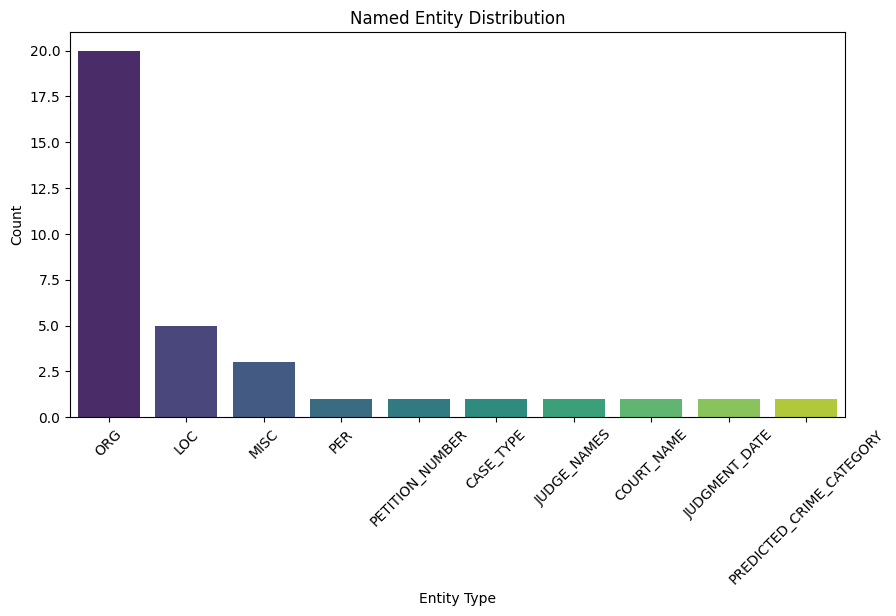

In [ ]:
visualize_named_entities(structured_entities)

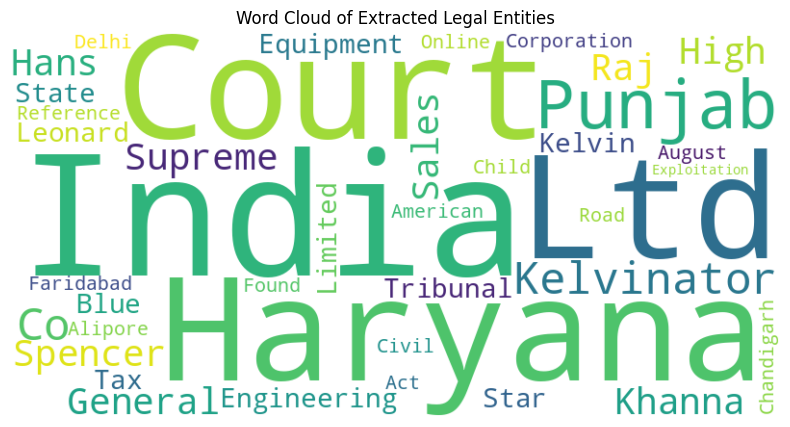

In [ ]:
visualize_wordcloud(structured_entities)